# Search for long range edges 

In this notebook, I will implement code to search for a long range edge(s) from a default `feems` by seeing if the likelihood increases with the addition of a certain edge. First, the search for the *best* edge will be done through a full grid search, wherein I iteratively add one long range edge after another over all pairs of nodes and check if this extra edge decreases the negative log likelihood. Second, I will implement a heuristic search by using a greedy approach to fit an edge between a pair of nodes that show maximum residuals with the default fit. 

To do this, I need to simulate a large empirical test case with many nodes. I will use the same corridor-barrier-corridor approach from previous simulations but with a much larger grid (40x80 is too large, for instance, 10x50 took 2 days to only get through ~1% of all edges). Keep total number of sampled nodes to about 40 maybe? 

## Changes to original code base

1. added code to calculate the negative log likelihood value for fit in `spatial_graph.py` (basically, adding `Objective` functions)

## Imports 

In [254]:
%load_ext autoreload
%autoreload 2
%load_ext memory_profiler

# base
import numpy as np
import networkx as nx
from sklearn.impute import SimpleImputer
import pkg_resources
import itertools as it
import math
from scipy.spatial.distance import pdist, squareform
import statsmodels.api as sm
from copy import deepcopy
import pandas as pd
import multiprocessing as mp

# viz
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs

# feems
from feems.utils import prepare_graph_inputs
from feems import SpatialGraph, Viz, Objective
from feems.sim import setup_graph, setup_graph_long_range, simulate_genotypes
from feems.spatial_graph import query_node_attributes
from feems.objective import comp_mats
from feems.cross_validation import run_cv
from feems.helper_funcs import plot_default_vs_long_range, comp_genetic_vs_fitted_distance, plot_estimated_vs_simulated_edges

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Simulation test case

### Exhaustive search 

This requires a search over a little less than $\sim \frac{d^2}{2}$ edges (for 128 nodes, it is about 7,800 edges). Using some kind of multithreading since this problem is embarassingly parellel. 


In [66]:
n_rows, n_columns = 8, 16
graph_def, _, _, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, barrier_startpt=2.5, barrier_endpt=6.5, corridor_w=0.5, barrier_w=0.1, barrier_prob=1.0)

lrn = [(0,38)]

## using 1.0 to ensure all nodes are sampled equally well (default params otherwise: 4x8 grid)
graph, coord, grid, edge = setup_graph_long_range(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_w=0.5, barrier_prob=1.0, long_range_nodes=lrn, long_range_edges=[1.5])

gen_test = simulate_genotypes(graph)

Simulating ~SNP 0
Simulating ~SNP 50
Simulating ~SNP 100
Simulating ~SNP 150
Simulating ~SNP 200
Simulating ~SNP 250
Simulating ~SNP 300
Simulating ~SNP 350
Simulating ~SNP 400
Simulating ~SNP 450
Simulating ~SNP 500
Simulating ~SNP 550
Simulating ~SNP 600
Simulating ~SNP 650
Simulating ~SNP 700
Simulating ~SNP 750
Simulating ~SNP 800
Simulating ~SNP 850
Simulating ~SNP 900
Simulating ~SNP 950


In [67]:
sp_Graph_def = SpatialGraph(gen_test, coord, grid, edge_def)

In [161]:
# create a list of all edges to add (since it is symmetric, we should expect d(d-1)/2 but some will be adjacent nodes so fewer than that)
lr = (tuple(i) for i in it.product(tuple(range(sp_Graph_def.n_observed_nodes)), repeat=2) if tuple(reversed(i)) > tuple(i))
final_lr = [x for x in list(lr) if x not in list(sp_Graph_def.edges)]

In [162]:
df = pd.DataFrame(index = np.arange(len(final_lr)), columns = ['nodes', 'nll'])

In [259]:
# function that takes in an edge, adds to default graph and returns negative log-lik
def add_edge_get_nll(val, lamb):
    edges_lr = deepcopy(edge_def)
    edges_lr = edges_lr.tolist()
    edges_lr.append(list(x+1 for x in val))
    sp_Graph = SpatialGraph(gen_test, coord, grid, np.array(edges_lr))
    sp_Graph.fit(lamb = float(lamb), verbose=False)
    obj = Objective(sp_Graph)
    obj._solve_lap_sys()
    obj._comp_mat_block_inv()
    obj._comp_inv_cov()
    return obj.neg_log_lik()

In [163]:
%%time
# for idx, val in enumerate(final_lr):
#     # creating a new edge vector (all default edges + 1 long range)
#     edges_lr = deepcopy(edge_def)
#     edges_lr = edges_lr.tolist()
#     edges_lr.append(list(x+1 for x in val))
#     sp_Graph = SpatialGraph(gen_test, coord, grid, np.array(edges_lr))
#     sp_Graph.fit(lamb = 10.0, verbose=False)

#     df.iloc[idx, 0] = val
#     df.iloc[idx, 1] = sp_Graph.nll

# tbh no difference in timings between above for loop and one-liner map
df['nodes'] = final_lr
df['nll'] = list(map(add_edge_get_nll, df.iloc[np.arange(len(final_lr)),0]))

# print nodes connected by THE edge to give lowest negative log likelihood
df.loc[df['nll'].astype(float).idxmin(),'nodes']

CPU times: user 7h 25min 18s, sys: 4min 15s, total: 7h 29min 34s
Wall time: 3h 39min 5s


(0, 38)

In [177]:
# %%time
# # sequential run for timing purposes
# df_test = pd.DataFrame(index = np.arange(100), columns = ['nodes', 'nll'])
# for idx, val in enumerate(final_lr[0:100]):
#     df_test.iloc[idx, 0] = val
#     df_test.iloc[idx, 1] = add_edge(val)

CPU times: user 5min 33s, sys: 4.04 s, total: 5min 37s
Wall time: 2min 48s


In [183]:
df_test

,nodes,nll
0,"(0, 2)",13988.335454
1,"(0, 3)",13951.909591
2,"(0, 4)",13895.398119
3,"(0, 5)",13854.259583
4,"(0, 6)",13861.783873
...,...,...
95,"(0, 98)",13950.784067
96,"(0, 99)",13976.136087
97,"(0, 100)",13929.84991
98,"(0, 101)",13870.904828


In [214]:
%%time
df_test['nodes'] = df.iloc[0:100,0]
df_test['nll'] = list(map(add_edge, df_test.iloc[0:100,0]))

CPU times: user 5min 2s, sys: 30.9 s, total: 5min 33s
Wall time: 2min 49s


In [213]:
# %%time
# # this section of code takes forever, some overhead in communication potentially
# pool = Pool(processes=mp.cpu_count())

# nll = pool.map(add_edge, (val for val in df_test['nodes']))

# pool.close()
# pool.join()

# df_test['nll'] = nll

KeyboardInterrupt: 

Based on initial testing on the simulations, I find that an exhaustive search works well in recovering the long range edge based on maximum decrease in negative log-likelihood. 

### Implementing a heuristic seach

We can use a data-driven apporach as before to find the pairs of nodes with highest residuals, and then search in a set region around the node. For instance, let's say, we get back (1,40) as the pair of nodes. We then implement a search in which we add edges between (0,40), (1,40), (2,40), ..., (2,41), etc. In this simple scheme, I will choose the six closest neighbors (forming a hexagon, if an interior node) to the selected nodes in the pair. 

In [218]:
# obtaining pairs of nodes with maximum residuals (TOP 1)
max_res_nodes = comp_genetic_vs_fitted_distance(sp_Graph_def, n_lre=1, lamb=10.0, plotFig=False)

constant-w/variance fit, converged in 123 iterations, train_loss=13990.5887471
lambda=10.0000000, alpha=0.6633522, converged in 14 iterations, train_loss=12458.5572596


ValueError: not enough values to unpack (expected 2, got 1)

In [269]:
# extracting closest neighbors to each node with maximum residuals
n1 = list(sp_Graph_def[max_res_nodes[0][0]])
n2 = list(sp_Graph_def[max_res_nodes[0][1]])

n1.append(max_res_nodes[0][0])
n2.append(max_res_nodes[0][1])

In [283]:
lr_heur = (tuple(i) for i in it.product(n1, n2))
# removing nodes that are already connected in the default graph 
final_lr_heur = [x for x in list(lr_heur) if x not in list(sp_Graph_def.edges)]

In [310]:
%%time
df_heur = pd.DataFrame(index = np.arange(len(final_lr_heur)), columns = ['nodes', 'nll'])

df_heur['nodes'] = final_lr_heur
df_heur['nll'] = list(map(add_edge_get_nll, df_heur.iloc[np.arange(len(final_lr_heur)),0]))

# print nodes connected by THE edge to give lowest negative log likelihood
df_heur.loc[df_heur['nll'].astype(float).idxmin(),'nodes']

CPU times: user 1min 2s, sys: 6.79 s, total: 1min 9s
Wall time: 35.5 s


(0, 38)

### Code to create an asymmetric convex hull around nodes

Below I will write some code to create a search region around the selected nodes in which I will incorporate nodes to use in the search. Important use cases to keep in mind:  
1. ensure that the two convex hulls are non-overlapping (i.e., at least 2 neighbors apart)  
2. set a manual threshold if the closest sampled node is too far  

#### Simulating an appropriate use-case

This simulation will have unsampled nodes (sparse graph) in both the corridor and barrier regions. 

In [3]:
n_rows, n_columns = 8, 12
graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, barrier_startpt=2.5, barrier_endpt=6.5, corridor_w=0.5, barrier_w=0.1, barrier_prob=1.0, sample_prob=0.5)

# gen_test_def = simulate_genotypes(graph_def)

# sp_Graph_def = SpatialGraph(gen_test_def, coord_def, grid_def, edge_def)

# proj_test = ccrs.EquidistantConic(central_longitude=6.0, central_latitude=4.0)
# # drawing the simulated graph 
# fig = plt.figure(dpi=100)
# ax = fig.add_subplot(1, 1, 1)  
# v = Viz(ax, sp_Graph_def, edge_width=.5, 
#         edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
#         obs_node_size=7.5, sample_pt_color="black", 
#         cbar_font_size=10)
# v.draw_samples()
# v.draw_edges(use_weights=False)
# v.draw_obs_nodes(use_ids=False)

In [5]:
# check nodes attributes and set long range nodes (0 is top-left)
print(query_node_attributes(graph_def,"sample_size").reshape(n_rows,n_columns))

[[20  0  0  0 20  0  0  0 20  0  0 20]
 [ 0  0 20  0  0 20  0 20 20  0  0 20]
 [ 0 20  0  0 20  0  0  0 20 20  0 20]
 [20  0  0 20  0 20 20 20  0 20  0 20]
 [20  0  0 20 20  0 20 20  0 20 20 20]
 [ 0 20 20  0  0  0  0  0 20 20 20 20]
 [ 0 20 20  0 20  0  0  0 20 20  0 20]
 [ 0 20  0  0  0  0  0  0 20 20  0 20]]


In [36]:
lrn = [(14,54)]

graph, _, grid, edge = setup_graph_long_range(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_w=0.5, barrier_prob=1.0, long_range_nodes=lrn, long_range_edges=[1.5], sample_prob=1.0)

# setting sample_size for nodes equal to the one from the default simulated graph
for n in np.arange(len(graph_def.nodes)):
    graph.nodes[n]["sample_size"] = graph_def.nodes[n]["sample_size"]

gen_test = simulate_genotypes(graph)

Simulating ~SNP 0
Simulating ~SNP 50
Simulating ~SNP 100
Simulating ~SNP 150
Simulating ~SNP 200
Simulating ~SNP 250
Simulating ~SNP 300
Simulating ~SNP 350
Simulating ~SNP 400
Simulating ~SNP 450
Simulating ~SNP 500
Simulating ~SNP 550
Simulating ~SNP 600
Simulating ~SNP 650
Simulating ~SNP 700
Simulating ~SNP 750
Simulating ~SNP 800
Simulating ~SNP 850
Simulating ~SNP 900
Simulating ~SNP 950


In [37]:
sp_Graph_def = SpatialGraph(gen_test, coord_def, grid_def, edge_def)

# ensuring sample coords match the default graph created
sample_sizes_dict = nx.get_node_attributes(graph_def, "sample_size")
pops_def = [[i] * int(sample_sizes_dict[i] / 2) for i in graph_def.nodes]
pops_def = list(it.chain.from_iterable(pops_def))
coord = grid[pops_def,:]

sp_Graph = SpatialGraph(gen_test, coord, grid, edge)

In [38]:
max_res_nodes = comp_genetic_vs_fitted_distance(sp_Graph_def, n_lre=1, lamb=10.0, plotFig=False)

constant-w/variance fit, converged in 128 iterations, train_loss=6184.4448289
lambda=10.0000000, alpha=0.6500999, converged in 19 iterations, train_loss=5824.8858646


In [39]:
permuted_idx = query_node_attributes(sp_Graph, "permuted_idx")
obs_perm_ids = permuted_idx[: sp_graph.n_observed_nodes]
max_idx = permuted_idx[np.unique(np.ravel(max_res_nodes))]
max_res_nodes = list(zip(max_idx[::2],max_idx[1::2]))

In [40]:
# need some kind of distance measure to get sampled nodes closest to pair of 
spl = dict(nx.all_pairs_shortest_path_length(sp_Graph_def,cutoff=5))

In [49]:
# get closest (within distance 3) AND sampled nodes to create a set of nodes to search over
n1 = [k for (k, v) in spl[max_res_nodes[0][0]].items() if v>0 and v<3 and k in np.array(np.where(query_node_attributes(graph,"sample_size")>0))]
n2 = [k for (k, v) in spl[max_res_nodes[0][1]].items() if v>0 and v<3 and k in np.array(np.where(query_node_attributes(graph,"sample_size")>0))]

n1.append(max_res_nodes[0][0])
n2.append(max_res_nodes[0][1])

In [50]:
lr_hull = (tuple(i) for i in it.product(n1, n2))
# removing nodes that are already connected in the default graph 
final_lr_hull = [x for x in list(lr_hull) if x not in list(sp_Graph_def.edges)]

In [51]:
%%time
df_hull = pd.DataFrame(index = np.arange(len(final_lr_hull)), columns = ['nodes', 'nll'])

df_hull['nodes'] = final_lr_hull
df_hull['nll'] = list(map(add_edge_get_nll, df_hull.iloc[np.arange(len(final_lr_hull)),0]))

# print nodes connected by THE edge to give lowest negative log likelihood
df_hull.loc[df_hull['nll'].astype(float).idxmin(),'nodes']

CPU times: user 1min 8s, sys: 1.23 s, total: 1min 9s
Wall time: 30.5 s


(14, 54)

### Running an exact search 

In [55]:
# create a list of all edges to add (since it is symmetric, we should expect d(d-1)/2 but some will be adjacent nodes so fewer than that)
# but only between sampled nodes
lr = (tuple(i) for i in it.product(tuple(permuted_idx), repeat=2) if tuple(reversed(i)) > tuple(i))
final_lr = [x for x in list(lr) if x not in list(sp_Graph_def.edges)]

In [63]:
%%time
df = pd.DataFrame(index = np.arange(len(final_lr)), columns = ['nodes', 'nll'])

df['nodes'] = final_lr
df['nll'] = list(map(add_edge_get_nll, df.iloc[np.arange(len(final_lr)),0]))

# print nodes connected by THE edge to give lowest negative log likelihood
df.loc[df['nll'].astype(float).idxmin(),'nodes']

CPU times: user 2h 52min 12s, sys: 3min, total: 2h 55min 12s
Wall time: 1h 16min 42s


(14, 54)

In [64]:
la = np.logspace(-6, 2, 20, dtype="float")
run_cv(sp_Graph_def, lamb_grid=la)
# 'best' lambda was between 5 and 14 (so 10.0 is a pretty good approximation) 


 fold= 0
iteration lambda=20/20 alpha=1/1
 fold= 1
iteration lambda=20/20 alpha=1/1
 fold= 2
iteration lambda=20/20 alpha=1/1
 fold= 3
iteration lambda=20/20 alpha=1/1
 fold= 4
iteration lambda=20/20 alpha=1/1

array([[[0.03047604],
        [0.0304767 ],
        [0.03047867],
        [0.03047826],
        [0.03040385],
        [0.03038246],
        [0.03029007],
        [0.03026853],
        [0.03016867],
        [0.03017585],
        [0.03010487],
        [0.03002431],
        [0.0299466 ],
        [0.02988919],
        [0.02986301],
        [0.0298616 ],
        [0.02987556],
        [0.02989078],
        [0.02989171],
        [0.02988234]],

       [[0.02956671],
        [0.02956665],
        [0.02951752],
        [0.02951816],
        [0.02945803],
        [0.02945809],
        [0.02938406],
        [0.02932642],
        [0.02928111],
        [0.02924097],
        [0.02916885],
        [0.02909166],
        [0.02901287],
        [0.02895756],
        [0.02892373],
        [0.02890058],
        [0.02888131],
        [0.02886522],
        [0.02885376],
        [0.02884456]],

       [[0.03175819],
        [0.0317579 ],
        [0.03175768],
        [0.031614  ],
        [0.03161379],
      

## Jul 7, 2021

### Methods

I follow the same procedure as outlined in `sim-long-range.ipynb` to create a default, skeletal graph with no long range edges and then add an edge to this graph to simulate genotypes from. This procedure works with no extra frills for the case with complete sampling, i.e., each node sampled and all individuals sampled at each node.  
However, for the case of incomplete sampling, the first step works as usual but the coordinates for the second graph needs to be adjusted based on the samples from the default graph. Another caveat is to look at the sampled nodes to see whether the long range nodes are actually being sampled (easy to check for small grid sizes, need an automated scheme for larger grids, but also takes much, much longer for exact solution)

Then, I compute two solutions:  
1. exact algorithm - add an edge between **all** pairs of nodes that are not already represented in default graph (slightly less than $\frac{d^2}{2})  
2. heuristic algorithm - only add edges between nodes that are located in the vicinity of the **one** pair of nodes with maximum residual (could be closest neighbors, could be an arbitrary convex hull to closest sampled nodes, etc.)

### Main takeways

It seems like both the exact search and heuristic search capture the long range edge easily, even in the case of uneven sampling. I will have to try more configurations/simulation parameters, but initial results are promising. 


## Further testing   

Below I will simulate scenarios with long range edges to try and break the model.   

### Close nodes

Nodes with long range migration, but full sampling. I will try different locations of the nodes (within barrier, corridor to corridor, etc.)

In [111]:
# function for conducting hull search with full sampling 
def search_hull_full_samp(graph_def, sp_Graph_def, lamb, max_res_nodes):
    spl = dict(nx.all_pairs_shortest_path_length(sp_Graph_def,cutoff=5))

    # get closest (within distance 3) AND sampled nodes to create a set of nodes to search over
    n1 = [k for (k, v) in spl[max_res_nodes[0][0]].items() if v>0 and v<3 and k in np.array(np.where(query_node_attributes(graph_def,"sample_size")>0))]
    n2 = [k for (k, v) in spl[max_res_nodes[0][1]].items() if v>0 and v<3 and k in np.array(np.where(query_node_attributes(graph_def,"sample_size")>0))]

    n1.append(max_res_nodes[0][0])
    n2.append(max_res_nodes[0][1])

    lr_hull = (tuple(i) for i in it.product(n1, n2))
    # removing nodes that are already connected in the default graph 
    final_lr_hull = [x for x in list(lr_hull) if x not in list(sp_Graph_def.edges)]

    df_hull = pd.DataFrame(index = np.arange(len(final_lr_hull)), columns = ['nodes', 'nll'])

    df_hull['nodes'] = final_lr_hull
    df_hull['nll'] = list(map(add_edge_get_nll, df_hull.iloc[np.arange(len(final_lr_hull)),0], np.repeat(lamb,len(final_lr_hull))))

    return(df_hull)

In [179]:
n_rows, n_columns = 8, 12
graph_def, _, _, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, barrier_startpt=2.5, barrier_endpt=6.5, corridor_w=0.5, barrier_w=0.1, barrier_prob=1.0)

# corridor - barrier
#lrn = [(13,27)]
# barrier - barrier
lrn = [(17,39)]

## using 1.0 to ensure all nodes are sampled equally well (default params otherwise: 4x8 grid)
graph, coord, grid, edge = setup_graph_long_range(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_w=0.5, barrier_prob=1.0, long_range_nodes=lrn, long_range_edges=[1.5])

gen_test = simulate_genotypes(graph)

Simulating ~SNP 0
Simulating ~SNP 50
Simulating ~SNP 100
Simulating ~SNP 150
Simulating ~SNP 200
Simulating ~SNP 250
Simulating ~SNP 300
Simulating ~SNP 350
Simulating ~SNP 400
Simulating ~SNP 450
Simulating ~SNP 500
Simulating ~SNP 550
Simulating ~SNP 600
Simulating ~SNP 650
Simulating ~SNP 700
Simulating ~SNP 750
Simulating ~SNP 800
Simulating ~SNP 850
Simulating ~SNP 900
Simulating ~SNP 950


In [180]:
sp_Graph_def = SpatialGraph(gen_test, coord, grid, edge_def)

In [172]:
max_res_nodes = comp_genetic_vs_fitted_distance(sp_Graph_def, n_lre=1, lamb=10.4, plotFig=False)

constant-w/variance fit, converged in 142 iterations, train_loss=9402.7166959
lambda=10.4000000, alpha=0.6594214, converged in 13 iterations, train_loss=8406.8832916


In [175]:
df_hull = search_hull_full_samp(graph_def, sp_Graph_def, 14.4, max_res_nodes)
df_hull.loc[df_hull['nll'].astype(float).idxmin(),'nodes']

(17, 74)

In [182]:
# adding above long range edge for comparison
edges_lr = deepcopy(edge_def)
edges_lr = edges_lr.tolist()
for x in [(17, 74)]:
    edges_lr.append(list(tuple(y+1 for y in x)))
sp_Graph_lr_hull = SpatialGraph(gen_test, coord, grid, np.array(edges_lr))

constant-w/variance fit, converged in 125 iterations, train_loss=10926.5718978
lambda=10.0000000, alpha=0.6687331, converged in 13 iterations, train_loss=9811.4463913


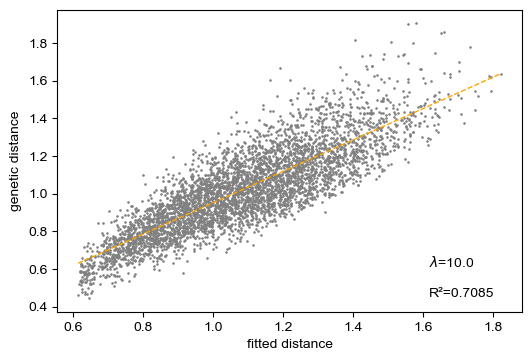

In [189]:
comp_genetic_vs_fitted_distance(sp_Graph_def, lamb=10.0, plotFig=True)

constant-w/variance fit, converged in 125 iterations, train_loss=10926.5718978
lambda=10.0000000, alpha=0.6687331, converged in 13 iterations, train_loss=9811.4463893
constant-w/variance fit, converged in 126 iterations, train_loss=10937.8465305
lambda=10.0000000, alpha=0.6930046, converged in 13 iterations, train_loss=9748.6871219


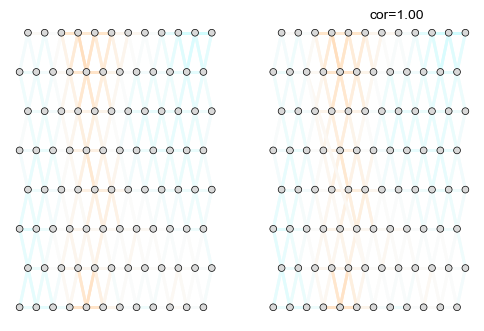

In [247]:
plot_default_vs_long_range(sp_Graph_def, sp_Graph_lr_hull, max_res_nodes=[(17,74)], lamb=10.0)

constant-w/variance fit, converged in 126 iterations, train_loss=10937.8465305
lambda=10.0000000, alpha=0.6930046, converged in 13 iterations, train_loss=9748.6871179


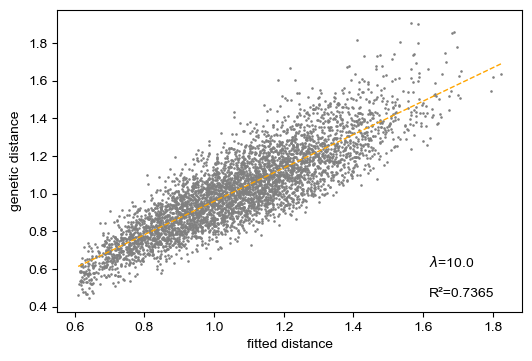

In [190]:
comp_genetic_vs_fitted_distance(sp_Graph_lr_hull, lamb=10.0, plotFig=True)

In [252]:
obj = Objective(sp_Graph_def)
obj._solve_lap_sys()
obj._comp_mat_block_inv()
obj._comp_inv_cov()
obj_lr = Objective(sp_Graph_lr_hull)
obj_lr._solve_lap_sys()
obj_lr._comp_mat_block_inv()
obj_lr._comp_inv_cov()
if obj_lr.neg_log_lik() < obj.neg_log_lik():
    print("Model with long-range edges fits better by %.2f units"%(-2*(obj_lr.neg_log_lik() - obj.neg_log_lik())))

Model with long-range edges fits better by 137.62 units


### Exact search for above cases 

In [176]:
n_rows, n_columns = 8, 12
graph_def, _, _, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, barrier_startpt=2.5, barrier_endpt=6.5, corridor_w=0.5, barrier_w=0.1, barrier_prob=1.0)

# corridor - barrier
lrn = [(17,39)]

## using 1.0 to ensure all nodes are sampled equally well (default params otherwise: 4x8 grid)
graph, coord, grid, edge = setup_graph_long_range(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_w=0.5, barrier_prob=1.0, long_range_nodes=lrn, long_range_edges=[1.5])

gen_test = simulate_genotypes(graph)

sp_Graph_def = SpatialGraph(gen_test, coord, grid, edge_def)

# create a list of all edges to add (since it is symmetric, we should expect d(d-1)/2 but some will be adjacent nodes so fewer than that)
lr = (tuple(i) for i in it.product(tuple(range(sp_Graph_def.n_observed_nodes)), repeat=2) if tuple(reversed(i)) > tuple(i))
final_lr = [x for x in list(lr) if x not in list(sp_Graph_def.edges)]

df = pd.DataFrame(index = np.arange(len(final_lr)), columns = ['nodes', 'nll'])

lamb_grid = np.geomspace(1e-6, 1e2, 20)[::-1]
cv_err = run_cv(sp_Graph_def, lamb_grid, n_folds=sp_Graph_def.n_observed_nodes, factr=1e10)
mean_cv_err = np.mean(cv_err, axis=0)
lamb = float(lamb_grid[np.argmin(mean_cv_err)])

df['nodes'] = final_lr
df['nll'] = list(map(add_edge_get_nll, df.iloc[np.arange(len(final_lr)),0], np.repeat(lamb, len(final_lr))))8

# print nodes connected by THE edge to give lowest negative log likelihood
print(df.loc[df['nll'].astype(float).idxmin(),'nodes'])

Simulating ~SNP 50
Simulating ~SNP 100
Simulating ~SNP 150
Simulating ~SNP 200
Simulating ~SNP 250
Simulating ~SNP 300
Simulating ~SNP 350
Simulating ~SNP 400
Simulating ~SNP 450
Simulating ~SNP 500
Simulating ~SNP 550
Simulating ~SNP 600
Simulating ~SNP 650
Simulating ~SNP 700
Simulating ~SNP 750
Simulating ~SNP 800
Simulating ~SNP 850
Simulating ~SNP 900
Simulating ~SNP 950

 fold= 0
iteration lambda=20/20 alpha=1/1
 fold= 1
iteration lambda=20/20 alpha=1/1
 fold= 2
iteration lambda=20/20 alpha=1/1
 fold= 3
iteration lambda=20/20 alpha=1/1
 fold= 4
iteration lambda=20/20 alpha=1/1
 fold= 5
iteration lambda=20/20 alpha=1/1
 fold= 6
iteration lambda=20/20 alpha=1/1
 fold= 7
iteration lambda=20/20 alpha=1/1
 fold= 8
iteration lambda=20/20 alpha=1/1
 fold= 9
iteration lambda=20/20 alpha=1/1
 fold= 10
iteration lambda=20/20 alpha=1/1
 fold= 11
iteration lambda=20/20 alpha=1/1
 fold= 12
iteration lambda=20/20 alpha=1/1
 fold= 13
iteration lambda=20/20 alpha=1/1
 fold= 14
iteration lambda=2

ValueError: object too deep for desired array

In [177]:
df['nll'] = list(map(add_edge_get_nll, df.iloc[np.arange(len(final_lr)),0], np.repeat(lamb, len(final_lr))))

# print nodes connected by THE edge to give lowest negative log likelihood
print(df.loc[df['nll'].astype(float).idxmin(),'nodes'])

(33, 40)


In [178]:
# corridor - barrier
lrn = [(13,27)]

graph, coord, grid, edge = setup_graph_long_range(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_w=0.5, barrier_prob=1.0, long_range_nodes=lrn, long_range_edges=[1.5])

gen_test = simulate_genotypes(graph)

sp_Graph_def = SpatialGraph(gen_test, coord, grid, edge_def)

# create a list of all edges to add (since it is symmetric, we should expect d(d-1)/2 but some will be adjacent nodes so fewer than that)
lr = (tuple(i) for i in it.product(tuple(range(sp_Graph_def.n_observed_nodes)), repeat=2) if tuple(reversed(i)) > tuple(i))
final_lr = [x for x in list(lr) if x not in list(sp_Graph_def.edges)]

df = pd.DataFrame(index = np.arange(len(final_lr)), columns = ['nodes', 'nll'])

lamb_grid = np.geomspace(1e-6, 1e2, 20)[::-1]
cv_err = run_cv(sp_Graph_def, lamb_grid, n_folds=sp_Graph_def.n_observed_nodes, factr=1e10)
mean_cv_err = np.mean(cv_err, axis=0)
lamb = float(lamb_grid[np.argmin(mean_cv_err)])

df['nodes'] = final_lr
df['nll'] = list(map(add_edge_get_nll, df.iloc[np.arange(len(final_lr)),0], np.repeat(lamb, len(final_lr))))

# print nodes connected by THE edge to give lowest negative log likelihood
print(df.loc[df['nll'].astype(float).idxmin(),'nodes'])

Simulating ~SNP 0
Simulating ~SNP 50
Simulating ~SNP 100
Simulating ~SNP 150
Simulating ~SNP 200
Simulating ~SNP 250
Simulating ~SNP 300
Simulating ~SNP 350
Simulating ~SNP 450
Simulating ~SNP 500
Simulating ~SNP 550
Simulating ~SNP 600
Simulating ~SNP 650
Simulating ~SNP 700
Simulating ~SNP 750
Simulating ~SNP 800
Simulating ~SNP 850
Simulating ~SNP 900
Simulating ~SNP 950

 fold= 0
iteration lambda=20/20 alpha=1/1
 fold= 1
iteration lambda=20/20 alpha=1/1
 fold= 2
iteration lambda=20/20 alpha=1/1
 fold= 3
iteration lambda=20/20 alpha=1/1
 fold= 4
iteration lambda=20/20 alpha=1/1
 fold= 5
iteration lambda=20/20 alpha=1/1
 fold= 6
iteration lambda=20/20 alpha=1/1
 fold= 7
iteration lambda=20/20 alpha=1/1
 fold= 8
iteration lambda=20/20 alpha=1/1
 fold= 9
iteration lambda=20/20 alpha=1/1
 fold= 10
iteration lambda=20/20 alpha=1/1
 fold= 11
iteration lambda=20/20 alpha=1/1
 fold= 12
iteration lambda=20/20 alpha=1/1
 fold= 13
iteration lambda=20/20 alpha=1/1
 fold= 14
iteration lambda=20/

### Multiple long range edge

I will now connect multiple disjoint nodes with long range edges to see if a greedy approach can recover the correct order. For this, I will first add edges between all nodes recovered in `max_res_nodes`, and then only consider nodes that are beyond the convex hull created around these nodes. 

In [124]:
n_rows, n_columns = 8, 12
graph_def, _, _, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, barrier_startpt=2.5, barrier_endpt=6.5, corridor_w=0.5, barrier_w=0.1, barrier_prob=1.0)

# corridor - barrier
lrn = [(14,29),(17,34),(24,38)]

graph, coord, grid, edge = setup_graph_long_range(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_w=0.5, barrier_prob=1.0, long_range_nodes=lrn, long_range_edges=[1.2,1.2,1.2])

gen_test = simulate_genotypes(graph)

sp_Graph_def = SpatialGraph(gen_test, coord, grid, edge_def)

Simulating ~SNP 0
Simulating ~SNP 50
Simulating ~SNP 100
Simulating ~SNP 150
Simulating ~SNP 200
Simulating ~SNP 250
Simulating ~SNP 300
Simulating ~SNP 350
Simulating ~SNP 400
Simulating ~SNP 450
Simulating ~SNP 500
Simulating ~SNP 550
Simulating ~SNP 600
Simulating ~SNP 650
Simulating ~SNP 700
Simulating ~SNP 750
Simulating ~SNP 800
Simulating ~SNP 850
Simulating ~SNP 900
Simulating ~SNP 950


In [134]:
max_res_nodes = comp_genetic_vs_fitted_distance(sp_Graph_def, n_lre=10, lamb=None, plotFig=False)


 fold= 0
iteration lambda=20/20 alpha=1/1
 fold= 1
iteration lambda=20/20 alpha=1/1
 fold= 2
iteration lambda=20/20 alpha=1/1
 fold= 3
iteration lambda=20/20 alpha=1/1
 fold= 4
iteration lambda=20/20 alpha=1/1
 fold= 5
iteration lambda=20/20 alpha=1/1
 fold= 6
iteration lambda=20/20 alpha=1/1
 fold= 7
iteration lambda=20/20 alpha=1/1
 fold= 8
iteration lambda=20/20 alpha=1/1
 fold= 9
iteration lambda=20/20 alpha=1/1
 fold= 10
iteration lambda=20/20 alpha=1/1
 fold= 11
iteration lambda=20/20 alpha=1/1
 fold= 12
iteration lambda=20/20 alpha=1/1
 fold= 13
iteration lambda=20/20 alpha=1/1
 fold= 14
iteration lambda=20/20 alpha=1/1
 fold= 15
iteration lambda=20/20 alpha=1/1
 fold= 16
iteration lambda=20/20 alpha=1/1
 fold= 17
iteration lambda=20/20 alpha=1/1
 fold= 18
iteration lambda=20/20 alpha=1/1
 fold= 19
iteration lambda=20/20 alpha=1/1
 fold= 20
iteration lambda=20/20 alpha=1/1
 fold= 21
iteration lambda=20/20 alpha=1/1
 fold= 22
iteration lambda=20/20 alpha=1/1
 fold= 23
iteration 

In [135]:
max_res_nodes

[(24, 81),
 (11, 26),
 (11, 24),
 (11, 60),
 (25, 81),
 (11, 29),
 (26, 81),
 (2, 11),
 (11, 25),
 (29, 81)]

In [161]:
edges_lr = deepcopy(edge_def)
edges_lr = edges_lr.tolist()
for val in max_res_nodes[0:5]:
    edges_lr.append(list(x+1 for x in val))
sp_Graph = SpatialGraph(gen_test, coord, grid, np.array(edges_lr))
sp_Graph.fit(lamb=14.4, verbose=False)

In [163]:
max_res_nodes2 = comp_genetic_vs_fitted_distance(sp_Graph, n_lre=5, lamb=10.0, plotFig=False)

constant-w/variance fit, converged in 126 iterations, train_loss=11126.0543278
lambda=10.0000000, alpha=0.8012238, converged in 12 iterations, train_loss=10070.7654283


In [164]:
max_res_nodes2

[(11, 36), (5, 70), (5, 47), (11, 49), (65, 76)]

### Findings

Quite complicated patterns, not very positive overall. *Interesting point is that the CV-estimated $\lambda$ is always between 6 and 14 for these simulations.*

1. If the long range edges are close-by (i.e., in neighboring rows but could be 2 to 5 columns apart), the search does not recover the edge, either with heuristic or exact. The estimated long range edge is not even in the right general direction.  
2. If I increase this distance to 2 rows apart, then the heuristic search works ok in recovering one of the nodes but not the other. However, the incorrectly recovered node is in the same general direction as the simulated long range node but much farther away. 
3. When I simulate multiple long range edges (disjoint), then I notice a more complicated pattern in estimation. One of the six simulated nodes is picked but not with its corresponding edge. Then a completely random node is picked (not in the general direction of any of the 6 nodes), and a bunch of edges from this node to some other nodes in the grid appear as having the highest absolute residuals. Quite weird. 